Practical 4 : Implementation of Neural Network on IMDB Dataset

In [4]:
import pandas as pd
import numpy as np

In [5]:
# !pip install keras_preprocessing
# !pip install embeddings
import re
import nltk
from nltk. corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [6]:
movie_reviews = pd.read_csv('/content/drive/MyDrive/ML/IMDB Dataset.csv')
movie_reviews.isnull().sum()
movie_reviews.shape

(50000, 2)

In [7]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
movie_reviews.review[2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

<Axes: xlabel='sentiment', ylabel='count'>

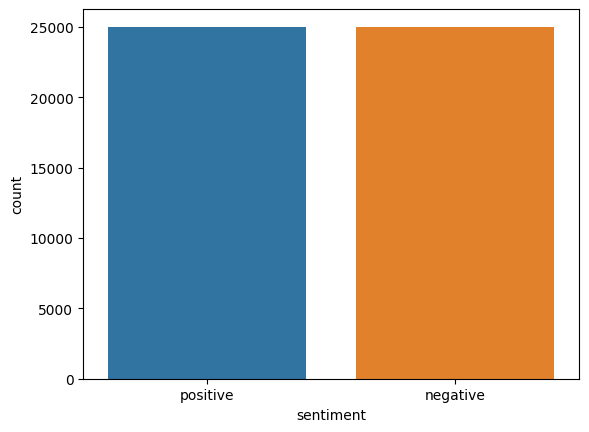

In [9]:
import seaborn as sns

sns.countplot(x='sentiment',data=movie_reviews)

In [10]:
def preprocessing_text(sen):
  #removing html tags
  # Removing html tags
  sentence = remove_tags(sen)

# Remove punctuations and numbers
  sentence= re.sub('[^a-zA-Z]',' ',sentence)

# Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+",' ',sentence)

# Removing multiple spaces
  sentence = re.sub(r'\s+',' ',sentence)

  return sentence

In [11]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('',text)

In [12]:
X = []

sentences = list(movie_reviews['review'])

for sen in sentences:
  X.append(preprocessing_text(sen))

In [13]:
movie_reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [14]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [15]:
y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0,y)))

In [16]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y1 = encoder.fit_transform(y)
Y = pd.get_dummies(y1).values

In [17]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [19]:
sentence = []
sentence.append('hello hi what')
sent = tokenizer.texts_to_sequences(sentence)
print(sent)

[[4936, 4853, 43]]


In [20]:
vocab_size  = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train,padding='post',maxlen=maxlen)
X_test = pad_sequences(X_test,padding='post',maxlen=maxlen)

In [21]:
from numpy import array
from numpy import asarray
from numpy import zeros

embedding_dictionary = dict()
glove_file = open('/content/drive/MyDrive/ML/glove.6B.100d.txt' ,encoding='utf8')

for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = asarray(records[1:],dtype='float32')
  embedding_dictionary[word] = vector_dimensions

glove_file.close()

In [22]:
embedding_matrix = zeros((vocab_size,100))

for word,index in tokenizer.word_index.items():
  embedding_vector = embedding_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [76]:
model = Sequential()
embedding_layer = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=maxlen,trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [77]:
print(model.summary())


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          9254700   
                                                                 
 flatten_10 (Flatten)        (None, 10000)             0         
                                                                 
 dense_30 (Dense)            (None, 64)                640064    
                                                                 
 dense_31 (Dense)            (None, 4)                 260       
                                                                 
 dense_32 (Dense)            (None, 1)                 5         
                                                                 
Total params: 9,895,029
Trainable params: 640,329
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [78]:
history = model.fit(X_train,y_train,batch_size=128,epochs=10,verbose=1,validation_split=0.2)

Epoch 1/10
250/250 [==============================] - 6s 20ms/step - loss: 0.6901 - acc: 0.5234 - val_loss: 0.6933 - val_acc: 0.5002
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.6864 - acc: 0.5272 - val_loss: 0.6560 - val_acc: 0.6687
Epoch 3/10
250/250 [==============================] - 4s 15ms/step - loss: 0.6336 - acc: 0.6490 - val_loss: 0.5892 - val_acc: 0.7279
Epoch 4/10
250/250 [==============================] - 6s 22ms/step - loss: 0.5528 - acc: 0.7469 - val_loss: 0.5666 - val_acc: 0.7333
Epoch 5/10
250/250 [==============================] - 4s 16ms/step - loss: 0.5110 - acc: 0.7721 - val_loss: 0.5581 - val_acc: 0.7266
Epoch 6/10
250/250 [==============================] - 4s 15ms/step - loss: 0.4717 - acc: 0.7951 - val_loss: 0.6087 - val_acc: 0.7284
Epoch 7/10
250/250 [==============================] - 5s 20ms/step - loss: 0.4514 - acc: 0.8050 - val_loss: 0.5946 - val_acc: 0.7374
Epoch 8/10
250/250 [==============================] - 4s 17ms/step - 

In [79]:
score = model.evaluate(X_test,y_test,verbose=1)

313/313 [==============================] - 1s 3ms/step - loss: 0.6010 - acc: 0.7090


In [80]:
print("Test Score",score[0])
print("Test Accuracy",score[1])

Test Score 0.6009941697120667
Test Accuracy 0.7089999914169312


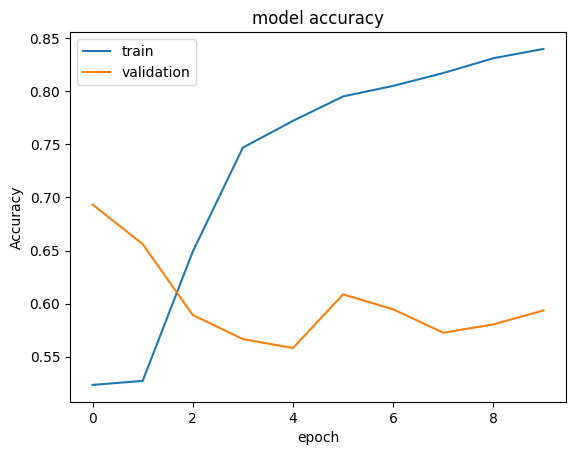

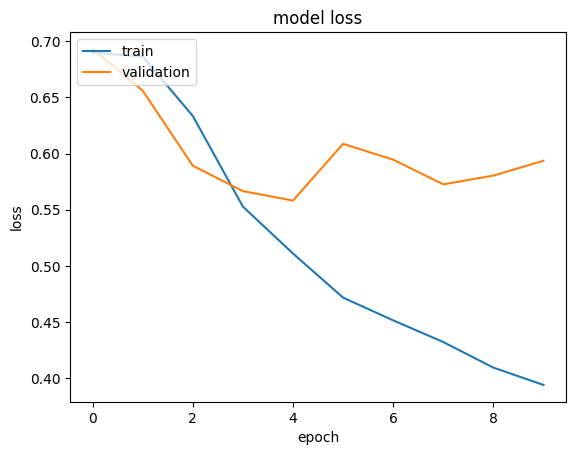

In [81]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'],loc='upper left')
plt.show()

In [82]:
# p = input("Enter your sentence: ")
p = "This is very good movie"
p = preprocessing_text(p)
print(p)

sentence = []
sentence.append(p)

sent = tokenizer.texts_to_sequences(sentence)
print(sent)

sent = pad_sequences(sent,padding='post',maxlen=maxlen)
print(sent)

(model.predict(sent) > 0.5).astype("int32")

This is very good movie
[[8, 5, 48, 45, 12]]
[[ 8  5 48 45 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0]]
1/1 [==============================] - 0s 64ms/step


array([[1]], dtype=int32)